# Running linear models on DEA indices

**Background:** This document presents an example of applying a linear model to analyse Landsat data extracted from Digital Earth Australia (DEA) to make inferences about physical processes. Here we are testing the rate of decline in vegetation condition during the dry season in NW Australia. Rainfall in this part of Australia is highly seasonal. During the dry season (April to October) there is very little rain and we assume that soil moisture declines throughout.

A common approach for assessing the likelihood of vegetation being dependent on groundwater is applying the 'green island' principle. This involves inferring gorudnwater use from vegetation that maintains higher condition during dry periods. In our area of interest, we expect that vegetation condition will decline much more rapidly in vegetation communities that are wholly reliant on surface water compared to communities that access groundwater (i.e. groundwater dependent ecosystems). We use NDVI as a proxy for vegetation condition.


**What does this document do?**

- Retrieve Landsat data for temporal and spatial extents
- Calculate NDVI and groupby months
- Demonstrate how to build a linear model to analyse the rate of decay in NDVI throughout the dry season
- Plot linear model parameters and use spatial patterns to infer distribuition of potential GDEs
- Export images with metadata as a textfile with same name as image file

**Requirements**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date**: November 2019

**Authors**: Neil Symington, Robbi Bishop-Taylor, Bex Dunn, Penny Kilgour

## Retrieving Landsat data
Here we import data Landsat data from the DEA. In our experience using the larger number of observations decreases our signal-to-noise ration and thus enables us to resolve landscape features at a higher resolution. Hence, for the actual data product we used the entire landsat archive and ran the processing through the raijin supercomputer.  However for this example we will only consider data from 2009-2019 from landsat 8.

### Import modules

In [1]:
%matplotlib inline
import sys
import warnings
import datacube
import matplotlib.pyplot as plt
from datacube.storage import masking
from datacube.helpers import write_geotiff
import calendar
import numpy as np
import xarray as xr

# Load custom DEA notebook functions
sys.path.append('../10_Scripts')
import DEADataHandling, DEAPlotting

# Dictionary for mapping month number to months names 
mnths =dict((k,v) for k,v in enumerate(calendar.month_name) if k!= 0)


In [2]:
# Connect to a datacube
dc = datacube.Datacube(app='LinearModels')


In [3]:

def linregress_3D(x, y):
    """
    
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three 
    dimensions (time,lat,lon). 
    Datasets can be provided in any order, but note that the regression slope 
    and intercept will be calculated for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, 
    and standard error on regression between the two datasets along their 
    aligned time dimension.  
    """ 
    # Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)

    
    #Compute data length, mean and standard deviation along time axis: 
    n = y.notnull().sum(dim='month')
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)

    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)

    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #6. Compute regression slope and intercept:
    LRslope     = cov/(xstd**2)
    LRintercept = ymean - xmean*LRslope  

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = LRslope/tstats

    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,LRslope,LRintercept,pval,stderr

def regression_pixel_drill(x, y, ax, slope, intercept, scatter_kwargs = None,
                          plot_kwargs = None):
    """
    Function  for plotting regression points and line on an axis
    @param x: x coordinate
    @param y: y coordinate
    @param ax: matplotlib axis
    @param scatter_kwargs: matplotlib keyword arguments for a scatter plot
    @param plot_kwargs: matplotlib keyword arguments for a plot
    """
    ndvi_pt = ndvi_dry.sel(x = x, y = y,
                           method = 'nearest').values
    months = ndvi_dry.month.values
    
    ax.scatter(months, ndvi_pt, **scatter_kwargs)
    
    # Get the slope and intercepth
    
    slope_ = slope.sel(x = x, y = y,
                       method = 'nearest').values
    
    intercept_ = intercept.sel(x = x, y = y,
                       method = 'nearest').values
    # Add a line to the graph
    
    xs = np.array([months[0], months[-1]])

    ys = np.array([slope_*v + intercept_ for v in xs])
    
    # Plot the line on the axis
    
    ax.plot(xs, ys, **plot_kwargs)
    

In [4]:
# Create spatial and temporal query


query = {'lat': (-14.85, -14.95),
         'lon': (128.6, 128.7),
         'time':('2009-01-01', '2019-01-10')}

# Define query coordinate reference system

query['crs'] = 'EPSG:4326'
query['output_crs'] = 'EPSG:28352'
query['resolution'] = (25.,25.)


In [5]:
# Load data for the specified query extent using `dc.load`:
ds = dc.load(product='ls8_nbar_albers', group_by='solar_day', **query
            )
ds

<xarray.Dataset>
Dimensions:          (time: 127, x: 432, y: 444)
Coordinates:
  * time             (time) datetime64[ns] 2013-04-26T01:31:31 ... 2019-01-05T01:29:38
  * y                (y) float64 8.347e+06 8.347e+06 ... 8.358e+06 8.358e+06
  * x                (x) float64 4.57e+05 4.57e+05 ... 4.677e+05 4.677e+05
Data variables:
    coastal_aerosol  (time, y, x) int16 517 551 634 580 536 ... 518 505 520 537
    blue             (time, y, x) int16 458 503 599 543 490 ... 434 422 444 468
    green            (time, y, x) int16 687 792 932 854 759 ... 608 589 632 679
    red              (time, y, x) int16 702 866 1108 969 827 ... 587 556 612 671
    nir              (time, y, x) int16 2447 2621 2818 2784 ... 1032 1102 1172
    swir1            (time, y, x) int16 2122 2377 2761 2552 ... 139 139 141 142
    swir2            (time, y, x) int16 1305 1490 1870 1689 ... 102 103 104 103
Attributes:
    crs:      EPSG:28352

## Adding code in to extract cloud free data only

In [6]:
#set cloudmasking threshold and load landsat nbart data
landsat_masked_prop = 0.90
ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart',
        masked_prop=landsat_masked_prop)


Loading ls5
    Loading 22 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 91 filtered ls8 timesteps
Combining and sorting ls5, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float32)


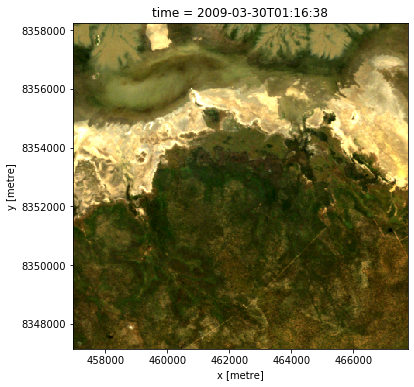

In [7]:
# View the rgb image

ls578_ds[['red', 'green', 'blue']].isel(time=1).to_array().plot.imshow(robust=True, figsize=(6,6))


Our study area is the margin of a sandy, unconfined aquifer system to the south and mud flats to the north. In the middle of the area are a number of 'islands' of thick vegetation (dark green). We want to assess the likelihood of these communities having some degree of groudnwater water dependence.

In [8]:
# Calculate NDVI

ndvi = ((ls578_ds.nir - ls578_ds.red)/(ls578_ds.nir + ls578_ds.red))


## Plotting NDVI

# Make a plot for each month

To investigate the difference in vegetation condition we plot the median and standard devation ndvi for each month


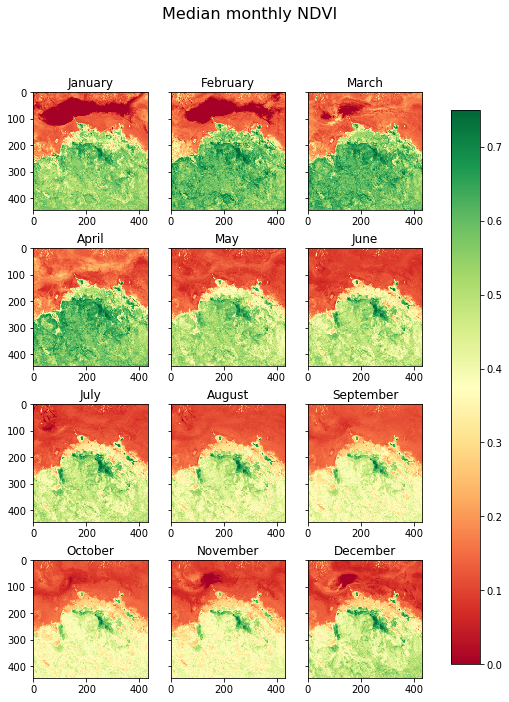

In [9]:
# Initialise the figure
fig, ax_array = plt.subplots(4,3, figsize = (8,11), sharey = True)

# Colour settings
grid_settings = {'cmap':'RdYlGn', 'vmin': 0, 'vmax': 0.75}

fig.suptitle('Median monthly NDVI', fontsize = 16)
# Iterate through the months
for i in range(12):
    # Assign subplots
    row,col = int(i/3), i%3
    
    #PLot image
    month_ndvi = ndvi.groupby('time.month').median(dim = 'time').isel(month = i)
    
    im = ax_array[row, col].imshow(month_ndvi[::-1], **grid_settings)
    # Add title
    ax_array[row, col].set_title(mnths[i + 1])

# Add colourbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
    
plt.show()

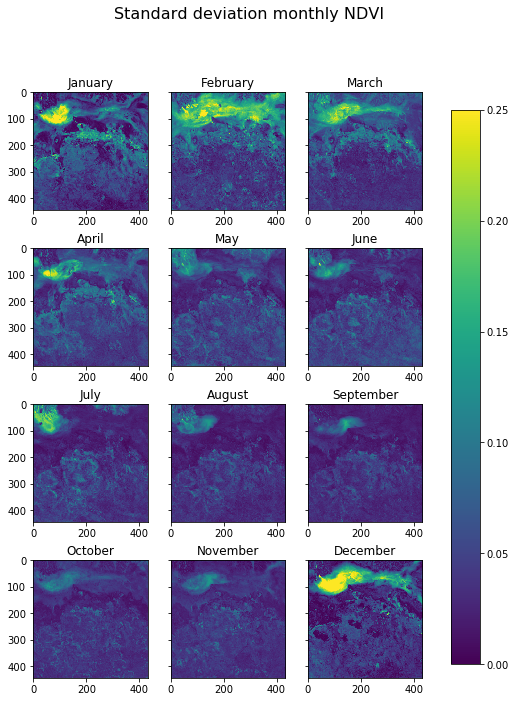

In [10]:
# Initialise the figure
fig, ax_array = plt.subplots(4,3, figsize = (8,11), sharey = True)

# Colour settings
grid_settings = {'cmap':'viridis', 'vmin': 0, 'vmax': 0.25}

fig.suptitle('Standard deviation monthly NDVI', fontsize = 16)
# Iterate through the months
for i in range(12):
    row,col = int(i/3), i%3
    
    #PLot image
    month_std_ndvi = ndvi.groupby('time.month').std(dim = 'time').isel(month = i)

    im = ax_array[row, col].imshow(month_std_ndvi[::-1],
                       **grid_settings)
    ax_array[row, col].set_title(mnths[i + 1])

    
# Add colourbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## Run trend analysis

From the median plots it appears that the vegetation condition declines from about April until January. This is somewhat counter intuitive given that we expect rains in December January. The very high standard deviation in the wet months suggest we may be getting some influence of spurious measurements, perhaps from cloud shadow and/ or surface water.

From this we decide the best way to test vegetation is to use April to November. UB looking at figures, more July - November (so 7 - 11)

In [11]:
# We group the data by dry season

dry_months = [4,5,6,7,8,9,10,11]

#Retrieve the dry months
ndvi_dryT = ndvi[ndvi['time.month'].isin(dry_months)]
ndvi_dry = ndvi_dryT.groupby('time.month').median(dim = 'time')


In [12]:
# To extract out median NDVI image, need to have individual values, not time based like above
ndvi_dry2 = ndvi_dryT.median(dim = 'time')

In [13]:
# Run the linear regression on the monthly ndvi
NDVIcov,NDVIcor,NDVIslope,NDVIintercept,NDVIpval,NDVIstderr = linregress_3D(ndvi_dry.month, ndvi_dry)

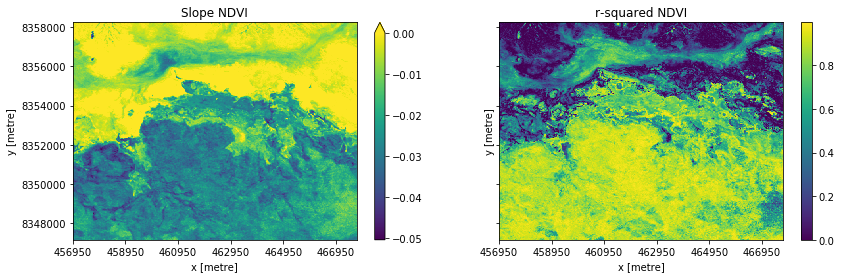

In [14]:
# View the slope and correlation coefficient
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,4),
                              sharey = True, sharex = True)


NDVIim1 = NDVIslope.plot(ax = ax1, vmin = NDVIslope.min(),
                vmax = 0.)
ax1.set_title('Slope NDVI')


NDVIr_squ = NDVIcor**2

NDVIim2 = NDVIr_squ.plot(ax = ax2)
ax2.set_title('r-squared NDVI')

# Better
ax1.xaxis.set_ticks(np.arange(ax1.get_xlim()[0],
                    ax1.get_xlim()[-1],2000))


plt.show()

From these plots it appears that most of the veg communities have a negative slope (i.e. declining NDVI/ vegetation condition). High r-squared values suggest a strong linear relationship in these areas. However there is a veg community at ~(463410, 8352460 )  with a positive or small negative slope and a low-rsquared. We conclude that these communities retain their condition during the dry season and thus have a greater probability of groundwater dependence.

### Exporting out NDVI image with 3 bands (slope, r squared, NDVI median value for dry period

In [15]:
# find the start and end date of images used to put in file name and metadata
startDate = str(ls578_ds.isel(time=0).time.values)[0:10]
endDate = str(ls578_ds.isel(time=-1).time.values)[0:10]

In [16]:
#Export out NDVI values, slope and r-squared for dry period specified

#Exporting NDVI slope into new dataset
NDVIslopeDS = NDVIslope.to_dataset(name='NDVI_slope')

# We can now add other attributes (Rsquared) into our dataset as new data variables:

NDVIslopeDS["NDVI_rsqu"] = NDVIr_squ
NDVIslopeDS["NDVI_dry_median"] = ndvi_dry2
#NDVIslopeDS

#converting type from float64 to float32 to reduce file size
NDVIslopeDS = NDVIslopeDS.astype(np.float32)
#Adding CRS back into dataset
NDVIslopeDS.attrs = ds.attrs
#NDVIslopeDS

#this writes the geotiff with 3 bands: NDVI_slope, NDVI-rsqu, NDVI_dry_median
write_geotiff('NDVI_landsat_dry_'+startDate[0:4]+'_'+endDate[0:4]+'.tif', NDVIslopeDS)
print('The file has been saved to NDVI_landsat_dry_'+startDate[0:4]+'_'+endDate[0:4]+'.tif')

#creating metadata file for NDVI_landsat_dry.tif
print ('The metadata file is being created')
f = open("NDVI_landsat_dry_"+startDate[0:4]+'_'+endDate[0:4]+".txt",'w')  #w - writes, r - reads; a- appends

f.write("NDVI of dry period (months " + str(dry_months[0])+ "-"+str(dry_months[-1]) + " from "+startDate+" to " +endDate+ "\n" +
        "NDVI_slope is the change in NDVI per month for best linear model, eg if NDVI_slope is near 0,"+"\n"+
        "NDVI values don't change much over the dry period. NDVI_rsqu is a measure of the extent" +"\n"+
        "to which the linear model explains variability in NDVI, eg if rsqu is 1, correlation with NDVI is high between months, "+ "\n" + 
        "ie you could predict NDVI if you knew the date as the large proportion of variance can be explained by the linear model." + "\n" +
        "NDVI_dry_median is the median NDVI for that month over the dry period and years specified."+"\n"+)
f.write(str(NDVIslopeDS)) #if don't have text to hand, could use this
f.close()

print ("The metadata file for NDVI_landsat_dry_"+startDate[0:4]+'_'+endDate[0:4]+'.tif has been saved to NDVI_landsat_dry_'+startDate[0:4]+'_'+endDate[0:4]+".txt")

The file has been saved to NDVI_landsat_dry_2009_2019.tif
The metadata file is being created
The metadata file for NDVI_landsat_dry_2009_2019.tif has been saved to NDVI_landsat_dry_2009_2019.txt


R-squared for high dry season NDVI recession =  0.9700771298779772
R-squared for low dry season NDVI recession =  0.007451238043463558


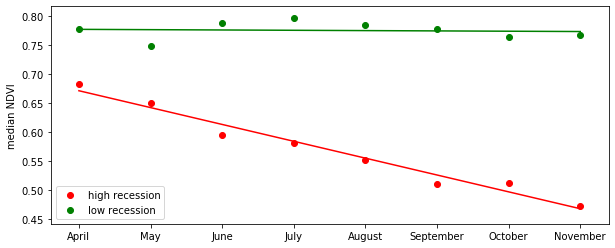

In [17]:
# To illustrate this we plot the points and regression slope for 

fig, (ax1) = plt.subplots(1, figsize = (10,4), sharey = True)

# First pixel is in the high recession veg community

scatter_kwargs = {'c': 'r','label': 'high recession'}
plot_kwargs = {'c': 'r'}

x,y = 462200, 8351840

regression_pixel_drill(x,y, ax1, NDVIslope, NDVIintercept, scatter_kwargs = scatter_kwargs,
                       plot_kwargs = plot_kwargs)

print('R-squared for high dry season NDVI recession = ', NDVIr_squ.sel(x = x, y = y,
                       method = 'nearest').values)

# Second pixel is in low high recession veg community

scatter_kwargs = {'c': 'g','label': 'low recession'}
plot_kwargs = {'c': 'g'}

x,y = 463410, 8352460

regression_pixel_drill(x,y, ax1, NDVIslope, NDVIintercept, scatter_kwargs = scatter_kwargs,
                       plot_kwargs = plot_kwargs)

print('R-squared for low dry season NDVI recession = ', NDVIr_squ.sel(x = x, y = y,
                       method = 'nearest').values)

ax1.set_xticklabels([mnths[n] for n in ax1.get_xticks()])

ax1.set_ylabel('median NDVI')

ax1.legend()



## Conclusion

Our conclusion from this investigation is that there are vegetation communities in the area of interest that appear to that show statistically negligible change in condition despite prolonged dry conditions. In contrast, adjacent vegetation communities decline linearly throughout the dry season as soil moisture becomes scarce. We hypothesise that the lack of recession is due to the availability of groundwater within the root zones throughout the dry season. Follow up work including field observations and chemistry are required to validate this.